In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from datetime import datetime

2023-02-08 15:03:21.779481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_prediction(history, X, Y, ax):
    W = history[-1]["W"] if "W" in history[0] else history[-1]["t_W"]
    b = history[-1]["b"] if "b" in history[0] else history[-1]["t_b"]
    Y_pred = W * X + b
    
    ax.scatter(X, Y) 
    ax.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red')
    ax.set_title("prediction")

def plot_history(history):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    keys = list(history[0])
    
    i = 0
    for row in axes:
        for ax in row:
            if i == 5:
                plot_prediction(history, X, Y, ax)
            else:
                ax.plot(np.arange(len(history)), list(map(lambda h: h[keys[i]], history)))
                ax.set_title(keys[i])
            i += 1
    
    plt.tight_layout()
    plt.show()

In [3]:
X = np.random.default_rng(1234).uniform(0, 10, size=100)
Y = X + np.random.default_rng(1234).normal(size=100)

In [4]:
test_X = np.array( [
    9.76699767, 3.80195735, 9.23246234, 2.61692424, 3.19097058,
    1.18091233, 2.41766293, 3.18533929, 9.64079245, 2.63649804,
    4.41006122, 6.09870809, 8.63621297, 8.63757671, 6.74881313,
    6.59874348, 7.35757698, 2.22753658, 1.72066185, 8.70414972,
    0.60138658, 6.83688909, 6.71238019, 6.11017981, 0.60137313,
    9.77769274, 4.38951627, 5.32595022, 0.03132287, 2.51267105,
    8.58490437, 4.25298351, 7.35818994, 9.22043217, 1.53474171,
    9.92259229, 1.82331783, 9.40112902, 0.86883055, 4.68210715,
    8.289892  , 2.81052263, 8.69091511, 9.76416574, 8.41713657,
    4.488736  , 3.7050843 , 4.82669437, 0.92181547, 2.26683105,
    5.36566237, 7.33231651, 4.48910789, 3.0550077 , 9.47359603,
    7.51033836, 4.7204846 , 4.5727588 , 7.46337803, 8.55399878,
    2.93501558, 7.33314499, 8.08830703, 8.87086974, 0.24833211,
    5.12549448, 6.1278568 , 2.80348952, 4.52131727, 5.31221089,
    9.88634563, 0.05978169, 2.01288286, 2.56875796, 3.40744839,
    0.53001963, 3.26494495, 1.98358207, 8.29214909, 6.37121629,
    0.85440736, 2.20160437, 6.81176006, 1.34410089, 9.56513691,
    1.36523977, 7.97702139, 4.98293523, 3.04707727, 2.34206052,
    8.93008166, 3.77536504, 0.76345452, 0.33806854, 4.61613322,
    8.73823961, 3.50609491, 8.23520552, 9.47199074, 0.6704071 
], dtype=np.float32)

Number of epochs:
$$E = [0,1000)$$

Current epoch is $e$:

$$e \in E$$

Loss/Cost is Mean Square Error:
$$MSE := C = \frac{1}{n} \sum_{i=0}^{n} (y_i - \hat{y})^2 = \frac{1}{n} \sum_{i=0}^{n} \big(y_i - (W_e x_i + b_e)\big)^2$$

Learning Rate is set to some low constant:
$$LR := L = 0.0001$$

Partial Derivative of loss with repsect to $W$, at epoch $e$:

$$\frac{\partial C}{\partial W_e} = \frac{1}{n} \sum_{i=0}^{n} 2 \big( y_i - (W_e x_i + b_e) \big) (-x_i) = -\frac{2}{n} \sum_{i=0}^{n} x_i (y_i - \hat{y}_i)$$

Partial Derivative of loss with respect to $b$, at eoch $e$:
$$\frac{\partial C}{\partial b_e} = - \frac{2}{n} \sum_{i=0}^{n} \big( y_i - (W_e x_i + b_e) \big) = - \frac{2}{n} \sum_{i=0}^{n} (y_i - \hat{y}_i)$$

Next epoch's $W$ is updated by:
$$W_0 \sim (\mu = 0, \sigma = 1)$$
$$W_{e+1} = W_e - L * \frac{\partial C}{\partial W_e}$$

Next epoch's $b$ is updated by:
$$b_0 \sim (\mu = 0, \sigma = 1)$$
$$b_{e+1} = b_e - L * \frac{\partial C}{\partial b_e}$$

In [5]:
W = np.random.normal(loc=0, scale=1)
b = np.random.normal(loc=0, scale=1)

L = 0.0001  # Learning Rate
E = 1000 # num epochs

W, b

(-0.023415719201718557, -0.4030972182230512)

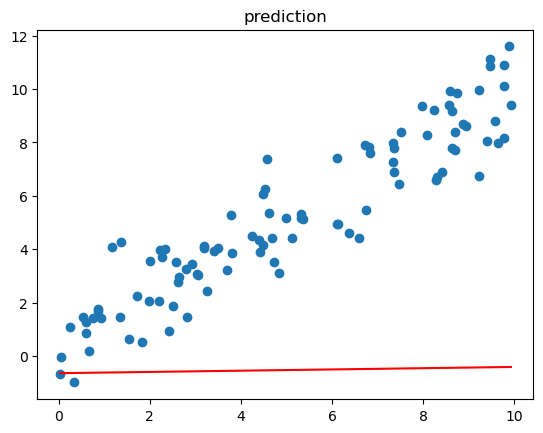

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_prediction([{"W":W, "b": b}], X, Y, ax)
plt.show()

In [7]:
def pythonic_learn(initial_W, initial_b, X, Y, E=1000, L=0.0001):
    W = initial_W
    b = initial_b

    n = float(len(X))

    history = []


    for e in range(E): 
        Y_pred = W*X + b  # The current predicted value of Y
        D_W = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt W
        D_b = (-2/n) * sum(Y - Y_pred)  # Derivative wrt b
        W = W - L * D_W  # Update W
        b = b - L * D_b  # Update b

        C = 1/n * ((Y - Y_pred)**2).sum()

        history.append({"C":C, "W":W, "b":b, "D_W":D_W, "D_b":D_b})
        
    return history

In [8]:
history = pythonic_learn(W, b, X, Y, E, L)

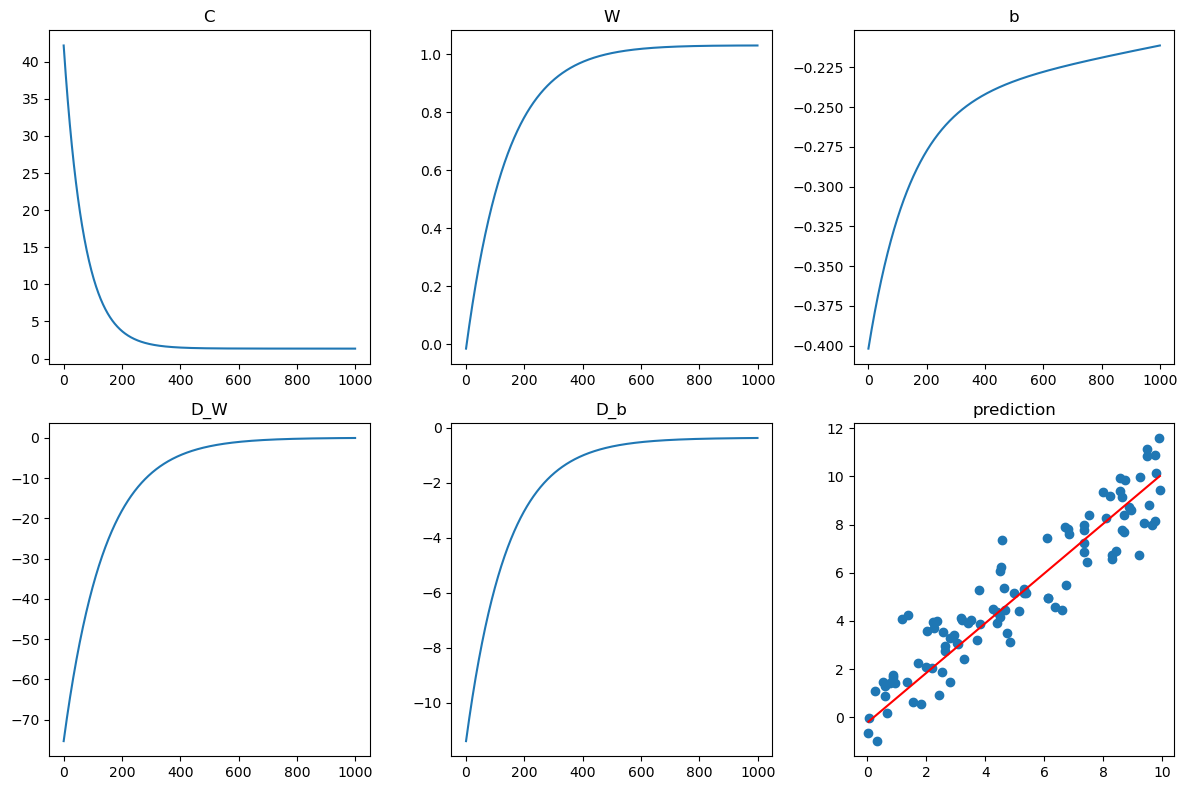

In [9]:
plot_history(history)

In [ ]:
# e for eager

def e_cost(Y, Y_pred):
    error_range = tf.subtract(Y, Y_pred)
    error_sq = tf.multiply(error_range, error_range)
    mse = tf.reduce_mean(error_sq)
    return mse

def e_get_pred(t_W, t_b, t_X):
    return tf.add(tf.multiply(t_W, t_X), t_b)

def tf_e_learn(initial_W, initial_b, X, Y, E=1000, L=0.0001):
    t_X = tf.constant(X.astype(np.float32))
    t_Y = tf.constant(Y.astype(np.float32))
    
    # t_W = tf.constant(initial_W)
    # t_b = tf.constant(initial_b)
    t_W = tf.Variable(initial_W)
    t_b = tf.Variable(initial_b)

    t_history = []

    for e in range(E):
        with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:
            # grad.watch(t_W)
            # grad.watch(t_b)
            t_Y_pred = e_get_pred(t_W, t_b, t_X)
            cost = e_cost(t_Y, t_Y_pred)

        # t_D_W = tape.gradient(cost, t_W)
        # t_D_b = tape.gradient(cost, t_b)
        t_D_W, t_D_b = tape.gradient(cost, [t_W, t_b])

        # t_W = tf.subtract(t_W, tf.multiply(L, t_D_W))
        # t_b = tf.subtract(t_b, tf.multiply(L, t_D_b))
        t_W.assign_sub( tf.multiply(L, t_D_W) )
        t_b.assign_sub( tf.multiply(L, t_D_b) )

        t_C = e_cost(t_Y, t_Y_pred)

        # t_history.append({"t_C": t_C, "t_W": t_W, "t_b": t_b, "t_D_W": t_D_W, "t_D_b": t_D_b})
        t_history.append({"t_C": t_C, "t_W": t_W.numpy(), "t_b": t_b.numpy(), "t_D_W": t_D_W, "t_D_b": t_D_b})
    
    return t_history

In [ ]:
t_history = tf_e_learn(W, b, X, Y, E, L)

In [ ]:
plot_history(t_history)

Explanation of [GraphDef](https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.10/tensorflow/g3doc/how_tos/tool_developers/index.md), particularly this line, in the section on "Freezing" (from v0.1.0 docs):

> What this does is load the `GraphDef`, pull in the values for all the variables from the latest checkpoint file, and then replace each `Variable` op with a `Const` that has the numerical data for the weights stored in its attributes. It then strips away all the extraneous nodes that aren't used for forward inference, and saves out the resulting `GraphDef` into an output file.

At least at the time it was saved a [protobuf](https://developers.google.com/protocol-buffers) `.pb` (bin) or `.pbtxt` (text) file.

It still is, in the form of saved model format.

Explanation of [tf.function](https://www.tensorflow.org/guide/function) and [graphs](https://www.tensorflow.org/guide/intro_to_graphs) in new docs, optimizations made in graph creation with [grappler](https://www.tensorflow.org/guide/graph_optimization), and the resulting [saved model format](https://www.tensorflow.org/guide/saved_model) when exporting a graph.

The Saved Model Format, of Tensorflow 2+, is not necessarily an optimized graphdef. It can include trained parameters, still as `tf.Variable`s along with the computation needed to run it, although does not require the original model building code to run. It's broken out to several APIs:

- `tf.saved_model` API:
    - `tf.saved_model.save(model, path_to_dir)`
    - `tf.saved_model.load(path_to_dir)`
- `tf.keras.Model`
- [checkpoints](https://www.tensorflow.org/guide/checkpoint)



In [ ]:
# g for graph

@tf.function
def tf_g_learn_one(t_W, t_b, t_X, t_Y, t_L):
    g_cost = lambda t_Y, t_Y_pred: tf.reduce_mean(
        tf.square(
            tf.subtract(t_Y, t_Y_pred)
        )
    )
    
    g_get_pred = lambda t_W, t_b, t_X: tf.add(
        tf.multiply(t_W, t_X),
        t_b
    )

    with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:
        # grad.watch(t_W)
        # grad.watch(t_b)
        t_Y_pred = g_get_pred(t_W, t_b, t_X)
        cost = g_cost(t_Y, t_Y_pred)

    # t_D_W = tape.gradient(cost, t_W)
    # t_D_b = tape.gradient(cost, t_b)
    t_D_W, t_D_b = tape.gradient(cost, [t_W, t_b])

    t_W.assign_sub( tf.multiply(t_L, t_D_W) )
    t_b.assign_sub( tf.multiply(t_L, t_D_b) )

    t_C = g_cost(t_Y, t_Y_pred)

    return {"t_C": t_C, "t_W": t_W, "t_b": t_b, "t_D_W": t_D_W, "t_D_b": t_D_b}
    

def tf_g_learn(initial_W, initial_b, X, Y, E=1000, L=0.0001):
    t_W = tf.Variable(initial_W) # float32
    t_b = tf.Variable(initial_b) # float32
    t_X = X.astype(np.float32)
    t_Y = Y.astype(np.float32)
    t_L = np.array(L).astype(np.float32)
    
    t_history = []

    for e in range(E):
        epoch_results = tf_g_learn_one(t_W, t_b, t_X, t_Y, t_L)

        t_history.append(epoch_results)
    
    return t_history

In [ ]:
t_history2 = tf_g_learn(W, b, X, Y, E, L)

In [ ]:
plot_history(t_history2)

In [ ]:
print(tf.autograph.to_code(tf_g_learn_one.python_function))

In [ ]:
class EagerModule(tf.Module):
    def __init__(self, initial_W=None, initial_b=None):
        super(EagerModule, self).__init__()
        self.t_W = tf.Variable(initial_W) if initial_W else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32))
        self.t_b = tf.Variable(initial_b) if initial_b else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32))
        
    def e_cost(self, Y, Y_pred):
        error_range = tf.subtract(Y, Y_pred)
        error_sq = tf.multiply(error_range, error_range)
        mse = tf.reduce_mean(error_sq)
        return mse

    def e_get_pred(self, t_W, t_b, t_X):
        return tf.add(tf.multiply(t_W, t_X), t_b)
        
    def __call__(self, X, Y, E=1000, L=0.0001): 
        t_X = tf.constant(X.astype(np.float32))
        t_Y = tf.constant(Y.astype(np.float32))

        self.t_history = []

        for e in range(E):
            with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:
                t_Y_pred = self.e_get_pred(self.t_W, self.t_b, t_X)
                cost = self.e_cost(t_Y, t_Y_pred)

            t_D_W, t_D_b = tape.gradient(cost, [self.t_W, self.t_b])

            self.t_W.assign_sub( tf.multiply(L, t_D_W) )
            self.t_b.assign_sub( tf.multiply(L, t_D_b) )

            t_C = self.e_cost(t_Y, t_Y_pred)

            self.t_history.append({"t_C": t_C, "t_W": self.t_W.numpy(), "t_b": self.t_b.numpy(), "t_D_W": t_D_W, "t_D_b": t_D_b})

In [ ]:
eager_module = EagerModule(W, b)
eager_module(X, Y, E, L)
plot_history(eager_module.t_history)

In [202]:
class GraphModule(tf.Module):
    def __init__(self, initial_W=None, initial_b=None, name=None):
        super(GraphModule, self).__init__(name=name)
        self.t_W = tf.Variable(initial_W, name="W") if initial_W else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32), name="W")
        self.t_b = tf.Variable(initial_b, name="b") if initial_b else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32), name="b")
        
    @tf.function(input_signature=[tf.TensorSpec(shape=(100,), dtype=tf.float32), tf.TensorSpec(shape=(100,), dtype=tf.float32)])
    def g_cost(self, t_Y, t_Y_pred):
        return tf.reduce_mean(
            tf.square(
                tf.subtract(t_Y, t_Y_pred)
            )
        )
    
    @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(100,), dtype=tf.float32)])
    def g_get_pred(self, t_W, t_b, t_X):
        return tf.add(
            tf.multiply(t_W, t_X),
            t_b
        )
        
    @tf.function(input_signature=[tf.TensorSpec(shape=(100,), dtype=tf.float32), tf.TensorSpec(shape=(100,), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32)])
    def __call__(self, t_X, t_Y, t_L):
        with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:
            t_Y_pred = self.g_get_pred(self.t_W, self.t_b, t_X)
            cost = self.g_cost(t_Y, t_Y_pred)

        t_D_W, t_D_b = tape.gradient(cost, [self.t_W, self.t_b])

        self.t_W.assign_sub( tf.multiply(t_L, t_D_W) )
        self.t_b.assign_sub( tf.multiply(t_L, t_D_b) )

        t_C = self.g_cost(t_Y, t_Y_pred)

        # return {"t_C": t_C, "t_W": self.t_W, "t_b": self.t_b, "t_D_W": t_D_W, "t_D_b": t_D_b}
        return [t_C, self.t_W, self.t_b, t_D_W, t_D_b]
        
    def train(self, X, Y, E=1000, L=0.0001):
        t_X = X.astype(np.float32)
        t_Y = Y.astype(np.float32)
        t_L = np.array(L).astype(np.float32)
        
        t_history = []
        
        for e in range(E):
            res_C, res_W, res_b, res_D_W, res_D_b = self.__call__(t_X, t_Y, t_L)

            t_history.append({"t_C": res_C, "t_W": res_W, "t_b": res_b, "t_D_W": res_D_b, "t_D_b": res_D_b})
            
        return t_history


class PureGraphModule(tf.Module):
    def __init__(self, initial_W=None, initial_b=None, name=None):
        super(PureGraphModule, self).__init__(name=name)
        self.t_W = tf.Variable(initial_W, name="W") if initial_W else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32), name="W")
        self.t_b = tf.Variable(initial_b, name="b") if initial_b else tf.Variable(tf.random.normal([], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32), name="b")
        
    @tf.function(input_signature=[tf.TensorSpec(shape=(100,), dtype=tf.float32), tf.TensorSpec(shape=(100,), dtype=tf.float32)])
    def g_cost(self, t_Y, t_Y_pred):
        return tf.reduce_mean(
            tf.square(
                tf.subtract(t_Y, t_Y_pred)
            )
        )
    
    @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(100,), dtype=tf.float32)])
    def g_get_pred(self, t_W, t_b, t_X):
        return tf.add(
            tf.multiply(t_W, t_X),
            t_b
        )
        
    @tf.function(input_signature=[tf.TensorSpec(shape=(100,))])
    def __call__(self, t_X):
        return self.g_get_pred(self.t_W, self.t_b, t_X)
        
    def train(self, X, Y, E=1000, L=0.0001):
        t_X = X.astype(np.float32)
        t_Y = Y.astype(np.float32)
        t_L = np.array(L).astype(np.float32)
        
        t_history = []
        
        for e in range(E):
            with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:
                t_Y_pred = self.g_get_pred(self.t_W, self.t_b, t_X)
                cost = self.g_cost(t_Y, t_Y_pred)

            t_D_W, t_D_b = tape.gradient(cost, [self.t_W, self.t_b])

            self.t_W.assign_sub( tf.multiply(t_L, t_D_W) )
            self.t_b.assign_sub( tf.multiply(t_L, t_D_b) )

            t_C = self.g_cost(t_Y, t_Y_pred)

            t_history.append({"t_C": t_C, "t_W": self.t_W.numpy(), "t_b": self.t_b.numpy(), "t_D_W": t_D_W, "t_D_b": t_D_b})
            
        return t_history

In [203]:
# shutdown previous session, if running
try:
    tf.summary.trace_off()
    tf.profiler.experimental.stop()
except:
    ...

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/func/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace
# Otherwise the summary will not see the graph.
# graph_module = GraphModule(np.array(W).astype(np.float32), np.array(b).astype(np.float32), name="linear_regression_graph")
pure_graph_module = PureGraphModule(np.array(W).astype(np.float32), np.array(b).astype(np.float32), name="linear_regression_graph")

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
tf.profiler.experimental.start(logdir)
# Call only one tf.function when tracing.
# g_t_history = graph_module.train(X,Y,E,L)
g_t_history = pure_graph_module.train(X,Y,E,L)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

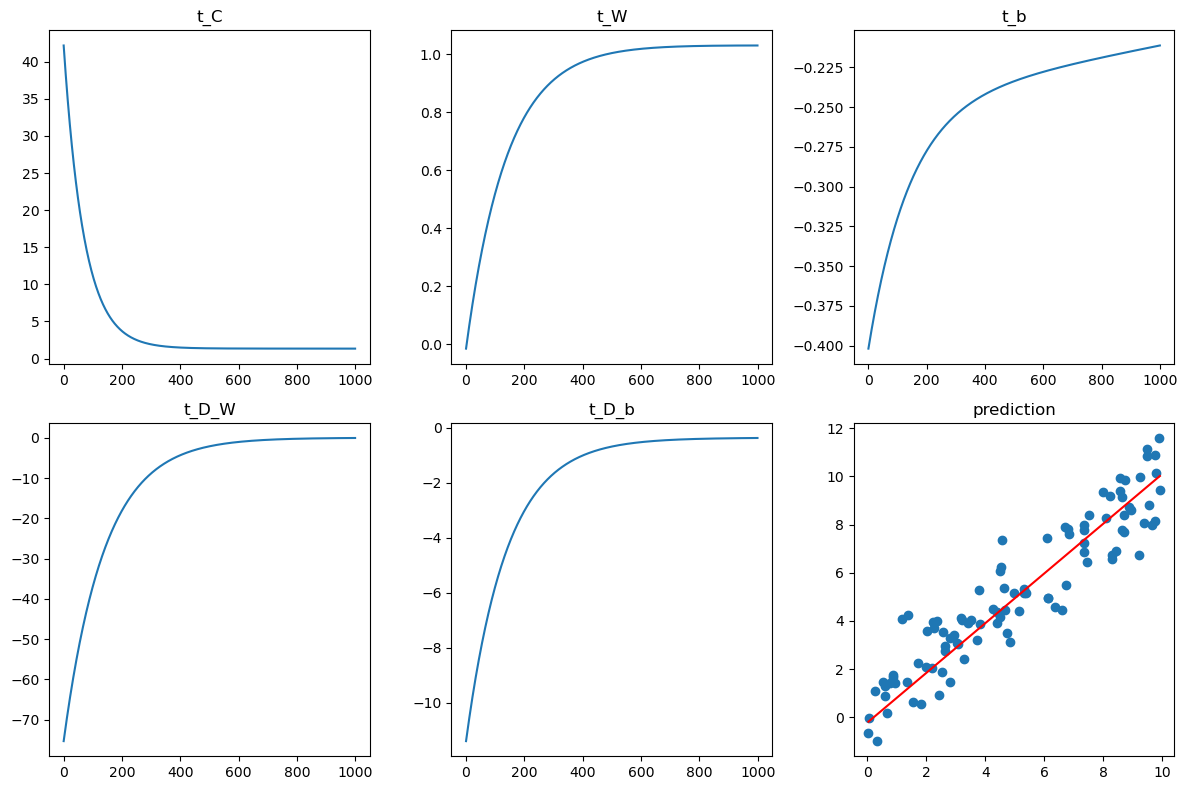

In [129]:
plot_history(g_t_history)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/func

In [ ]:
tf.saved_model.save(eager_module, 'saved_models/eag')

In [204]:
# tf.saved_model.save(graph_module, 'saved_models/gra/1/', signatures={'serving_default': graph_module.__call__.get_concrete_function(*graph_module.__call__.input_signature)})
tf.saved_model.save(pure_graph_module, 'saved_models/gra/1/', signatures={'serving_default': pure_graph_module.__call__.get_concrete_function(*pure_graph_module.__call__.input_signature)})

INFO:tensorflow:Assets written to: saved_models/gra/1/assets


INFO:tensorflow:Assets written to: saved_models/gra/1/assets


In [205]:
loaded_g_module = tf.saved_model.load('saved_models/gra/1')

In [206]:
loaded_g_module.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, t_X) at 0x1F89FF400>})

In [207]:
# loaded_g_module(X.astype(np.float32), Y.astype(np.float32), np.array(L).astype(np.float32))
loaded_g_module(test_X)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 9.8529625 ,  3.706414  ,  9.302162  ,  2.485322  ,  3.0768359 ,
        1.0056143 ,  2.2799973 ,  3.071033  ,  9.722918  ,  2.5054913 ,
        4.3330216 ,  6.073052  ,  8.687769  ,  8.689175  ,  6.7429385 ,
        6.5883026 ,  7.3702264 ,  2.084086  ,  1.5617876 ,  8.757772  ,
        0.4084543 ,  6.833695  ,  6.705397  ,  6.0848727 ,  0.4084404 ,
        9.863983  ,  4.3118515 ,  5.27678   , -0.17895573,  2.3778965 ,
        8.634899  ,  4.1711645 ,  7.370858  ,  9.289766  ,  1.3702102 ,
       10.013292  ,  1.6675673 ,  9.47596   ,  0.6840362 ,  4.6133456 ,
        8.330912  ,  2.6848114 ,  8.744137  ,  9.850044  ,  8.462027  ,
        4.4140906 ,  3.6065934 ,  4.7623324 ,  0.73863333,  2.124576  ,
        5.317701  ,  7.3441973 ,  4.414474  ,  2.9367356 ,  9.550632  ,
        7.527636  ,  4.652891  ,  4.50067   ,  7.4792466 ,  8.603054  ,
        2.8130925 ,  7.3450513 ,  8.123192  ,  8.929567  ,  0.04465681,
        5.070225

In [ ]:
# no functions available, because none wrapped in tf.function
# only weight and bias available
loaded_e_module = tf.saved_model.load('saved_models/eag')

In [ ]:
loaded_e_module.t_W, loaded_e_module.t_b

The `saved_model.pb file` stores the actual TensorFlow program, or model, and a set of [named signatures](https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export), each identifying a function that accepts tensor inputs and produces tensor outputs.

In [ ]:
!ls -al saved_models/gra/1

Signatures are used by the [saved model CLI](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface)

In [ ]:
!saved_model_cli show --dir saved_models/gra/1 --tag_set serve

The variables directory contains a standard training [checkpoint](https://www.tensorflow.org/guide/checkpoint).

In [ ]:
!ls -al saved_models/gra/1/variables

The assets directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables. It is unused in this example.

A SavedModel from Keras provides [more details](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details) than a plain `__call__` to address more advanced cases of fine-tuning. TensorFlow Hub recommends to provide the following of those, if applicable, in SavedModels shared for the [purpose of fine-tuning](https://www.tensorflow.org/guide/keras/transfer_learning):

- If the model uses dropout or another technique in which the forward pass differs between training and inference (like batch normalization), the `__call__` method takes an optional, Python-valued `training=` argument that defaults to `False` but can be set to `True`.
  - [difference between](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute) `trainable` attribute (boolean on layer objects to freeze or not) and the `training` argument in `__call__` (inference vs training mode)
- Next to the `__call__` attribute, there are `.variable` and `.trainable_variable` attributes with the corresponding lists of variables. A variable that was originally trainable but is meant to be frozen during fine-tuning is omitted from `.trainable_variables`.
- For the sake of frameworks like Keras that represent weight regularizers as attributes of layers or sub-models, there can also be a `.regularization_losses` attribute. It holds a list of zero-argument functions whose values are meant for addition to the total loss.

The pure graph module can be converted to a tfjs graph model. The non-pure one can't, as `tensorflowjs_converter` will raise an error about a `StatefulPartionCall`. This is because it's `tf.function`-wrapped `__call__` references and assigns to it's variables, `self.t_W` and `self.t_b`; and it holds a gradient tape. While the non-pure graph model can be saved as a SavedModel, can be loaded back in to TensorFlow, and can be re-trained upon, it can't be converted to a pure graph model form expected in TensorFlow.js's `loadGraphModel`.

In [208]:
!rm -rf ./saved_modules/gra_web/*
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default ./saved_models/gra/1 ./saved_models/gra_web
!tensorflowjs_converter --quantize_float16 --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default ./saved_models/gra/1 ./saved_models/gra_web

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB

Writing weight file ./saved_models/gra_web/model.json...


---

Other:

- [Frozen Graph](https://leimao.github.io/blog/Save-Load-Inference-From-TF2-Frozen-Graph/)
- [keras model saving options](https://keras.io/getting_started/faq/#what-are-my-options-for-saving-models)
  - The "whole model" format can be converted to TensorFlow.js Layers format, which can be loaded directly into TensorFlow.js for inference or for further training.
  - Keras models are usually saved via model.save(filepath), which [produces a single HDF5 (.h5) file](https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format) containing both the model topology and the weights.
- [Saving tf.functions](https://www.tensorflow.org/guide/intro_to_modules#saving_functions)
- [TF 2 Detection Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)
- [TF Hub image signatures](https://www.tensorflow.org/hub/common_signatures/images)
- [TF Graph Optimizations](http://web.stanford.edu/class/cs245/slides/TFGraphOptimizationsStanford.pdf)
- [TF XLA](https://www.tensorflow.org/xla)

Tensorflow.js stuff:

- [Getting Started](https://www.tensorflow.org/js/tutorials)
- [Graph model](https://js.tensorflow.org/api/latest/#class:GraphModel)
- [Importing a saved graphDef](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model)
- [Tensorflow Hub](https://www.tensorflow.org/hub/)
  - [feature vectors](https://tfhub.dev/google/tfjs-model/imagenet/mobilenet_v3_large_075_224/feature_vector/5/default/1)
- [tfjs models](https://github.com/tensorflow/tfjs-models)
- [tfjs converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter)
- [tensorflow js (python package)](https://pypi.org/project/tensorflowjs/) - lets you do `tfjs.converters.save_keras_model(model, tfjs_target_dir)`
- [tfjs graph -> python converter](https://pypi.org/project/tfjs-graph-converter/) - written by a 3rd party, needs to be verified

---

In [ ]:
# # Create base model
# base_model = keras.applications.Xception(
#     weights='imagenet',
#     input_shape=(150, 150, 3),
#     include_top=False)
# # Freeze base model
# base_model.trainable = False

# # Create new model on top.
# inputs = keras.Input(shape=(150, 150, 3))
# x = base_model(inputs, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
# optimizer = keras.optimizers.Adam()

# # Iterate over the batches of a dataset.
# for inputs, targets in new_dataset:
#     # Open a GradientTape.
#     with tf.GradientTape() as tape:
#         # Forward pass.
#         predictions = model(inputs)
#         # Compute the loss value for this batch.
#         loss_value = loss_fn(targets, predictions)

#     # Get gradients of loss wrt the *trainable* weights.
#     gradients = tape.gradient(loss_value, model.trainable_weights)
#     # Update the weights of the model.
#     optimizer.apply_gradients(zip(gradients, model.trainable_weights))

In [ ]:
# imported = tf.saved_model.load('path_to_saved_model_dir')

# optimizer = tf.keras.optimizers.SGD(0.05)

# def train_step():
#     with tf.GradientTape() as tape:
#         loss = (10. - imported(tf.constant(2.))) ** 2
#     variables = tape.watched_variables()
#     grads = tape.gradient(loss, variables)
#     optimizer.apply_gradients(zip(grads, variables))
#     return loss

# for _ in range(10):
#     # "v" approaches 5, "loss" approaches 0
#     print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))